# Vehicle Complaints NLP Analysis

## Package Loading

In [7]:
import pandas as pd
import numpy as np
import re
import spacy
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib
from scipy import sparse
import seaborn as sns
import matplotlib.pyplot as plt
from spacy.matcher import PhraseMatcher
from sklearn.metrics import calinski_harabasz_score
from sklearn.decomposition import TruncatedSVD
from wordcloud import WordCloud, STOPWORDS

## Data Wrangling

In [8]:
df = pd.read_parquet("complaints_2015_cleaned.parquet")
print(df.head())

  CMPLID   ODINO             MFR_NAME MAKETXT      MODELTXT YEARTXT CRASH  \
0  79432  516612  General Motors, LLC     GMC  ENVOY DENALI    2007     N   
1  79433  516612  General Motors, LLC     GMC  ENVOY DENALI    2007     N   
2  79434  516612  General Motors, LLC     GMC  ENVOY DENALI    2007     N   
3  79435  516612  General Motors, LLC     GMC  ENVOY DENALI    2007     N   
4  79436  516612  General Motors, LLC     GMC  ENVOY DENALI    2007     N   

   FAILDATE FIRE INJURED  ...     LDATE  \
0  20150825    N       0  ...  20160106   
1  20150825    N       0  ...  20160106   
2  20150825    N       0  ...  20160106   
3  20150825    N       0  ...  20160106   
4  20150825    N       0  ...  20160106   

                                              CDESCR CMPL_TYPE POLICE_RPT_YN  \
0  WIRING TO FUEL PUMP BURNT...2007 GMC ENVOY DEN...      EVOQ             N   
1  WIRING TO FUEL PUMP BURNT...2007 GMC ENVOY DEN...      EVOQ             N   
2  WIRING TO FUEL PUMP BURNT...2007 GM

In [9]:
df.loc[0, 'CDESCR']

'WIRING TO FUEL PUMP BURNT...2007 GMC ENVOY DENALI  WHEN DEAD ON HIGHWAY. ..UPDATED 01/07/16 *BF    WHITE BEAR LAKE SUPERSTORE CORRECTED THE PROBLEM BY INSTALLING A NEW ALTERNATOR, IGNITION SWITCH, AND REPLACING THE BATTERY.  *TR'

In [10]:
df.loc[0, 'COMPDESC']

'FUEL SYSTEM, GASOLINE:DELIVERY:FUEL PUMP'

In [11]:
df.shape

(872933, 25)

## Basic Unstructured Data Analysis

### Step 1: Clean & Normalize the CDESCR Narratives

In [ ]:

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])  # NER comes later

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"\*?[A-Z]{2,}\s*|\*+[A-Z]+\*+", "", text)  # remove update tags like '*BF', '*TR'
    text = re.sub(r"[^\w\s]", " ", text)  # remove punctuation
    text = re.sub(r"\s+", " ", text)  # remove extra whitespace
    doc = nlp(text.strip())
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return " ".join(tokens)

tqdm.pandas()
df["cd_text"] = df["CDESCR"].fillna("").progress_apply(preprocess_text)

/Users/augus/anaconda3/envs/ml/lib/python3.12/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.8.0) was trained with spaCy v3.8.0 and may not be 100% compatible with the current version (3.7.5). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
  0%|          | 2214/872933 [00:05<35:52, 404.48it/s]

In [39]:
df.to_parquet("complaints_with_cdtext.parquet", index=False)
df = pd.read_parquet("complaints_with_cdtext.parquet")

### Step 2: Extract Named Entities and Key Terms

In [40]:

nlp = spacy.load("en_core_web_sm")

texts = df["CDESCR"].fillna("").tolist()

entities_list = []
for doc in tqdm(nlp.pipe(texts, batch_size=100), total=len(texts)):
    ents = [ent.text.lower() for ent in doc.ents if ent.label_ in ["ORG", "PRODUCT", "GPE", "NORP"]]
    entities_list.append(ents)

df["entities"] = entities_list

/Users/augus/anaconda3/envs/ml/lib/python3.12/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.8.0) was trained with spaCy v3.8.0 and may not be 100% compatible with the current version (3.7.5). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
100%|██████████| 872933/872933 [44:07<00:00, 329.71it/s]


In [41]:
df.to_parquet("complaints_with_entities.parquet", index=False)
df = pd.read_parquet("complaints_with_entities.parquet")

### Step 3: Topic Modeling via LDA

In [42]:
vectorizer = CountVectorizer(max_df=0.9, min_df=10, max_features=5000)
X = vectorizer.fit_transform(df["cd_text"])

lda = LatentDirichletAllocation(n_components=8, random_state=42, verbose=1)
lda.fit(X)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


LatentDirichletAllocation(n_components=8, random_state=42, verbose=1)

In [43]:
joblib.dump(lda, "lda_model.pkl")
joblib.dump(vectorizer, "lda_vectorizer.pkl")
sparse.save_npz("lda_doc_term_matrix.npz", X)
X = sparse.load_npz("lda_doc_term_matrix.npz")

In [44]:
# Load saved models
lda = joblib.load("lda_model.pkl")
vectorizer = joblib.load("lda_vectorizer.pkl")

# Get feature names
feature_names = vectorizer.get_feature_names_out()

# Display topics
def display_topics(model, feature_names, no_top_words=10):
    for idx, topic in enumerate(model.components_):
        print(f"Topic {idx}: ", [feature_names[i] for i in topic.argsort()[-no_top_words:]])

display_topics(lda, feature_names, 10)

Topic 0:  ['problem', 'go', 'turn', 'time', 'come', 'drive', 'start', 'light', 'engine', 'car']
Topic 1:  ['time', 'light', 'steering', 'control', 'turn', 'drive', 'stop', 'vehicle', 'car', 'brake']
Topic 2:  ['car', 'lock', 'passenger', 'fire', 'drive', 'open', 'driver', 'rear', 'vehicle', 'door']
Topic 3:  ['drive', 'dealer', 'own', 'repair', 'manufacturer', 'mileage', 'state', 'failure', 'contact', 'vehicle']
Topic 4:  ['bag', 'nhtsa', 'receive', 'number', 'available', 'part', 'manufacturer', 'repair', 'recall', 'contact']
Topic 5:  ['fix', 'dealer', 'problem', 'airbag', 'tell', 'tire', 'issue', 'vehicle', 'car', 'recall']
Topic 6:  ['recall', 'replace', 'safety', 'leak', 'system', 'cause', 'problem', 'fuel', 'vehicle', 'issue']
Topic 7:  ['speed', 'gear', 'time', 'problem', 'ford', 'car', 'drive', 'issue', 'transmission', 'vehicle']


In [45]:
topic_distributions = lda.transform(X)  # shape = (n_documents, n_topics)
np.save("topic_distributions.npy", topic_distributions)
topic_distributions = np.load("topic_distributions.npy")

In [46]:
df["dominant_topic"] = topic_distributions.argmax(axis=1)
df.to_parquet("complaints_with_topics.parquet", index=False)

In [47]:
df = pd.read_parquet("complaints_with_topics.parquet")

### Step 4: Narrative Clustering (Updated with CHI evaluation)

100%|██████████| 8/8 [00:11<00:00,  1.39s/it]


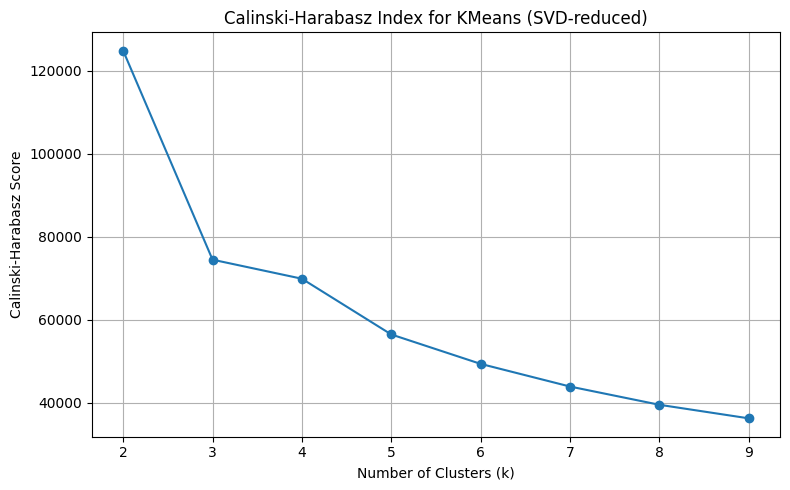

In [48]:
tfidf = TfidfVectorizer(max_df=0.9, min_df=10)
X_tfidf = tfidf.fit_transform(df["cd_text"])

# Dimensionality reduction to speed up CHI computation
svd = TruncatedSVD(n_components=100, random_state=0)
X_reduced = svd.fit_transform(X_tfidf)

scores = []
k_values = range(2, 10)

for k in tqdm(k_values):
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(X_reduced)
    score = calinski_harabasz_score(X_reduced, labels)
    scores.append(score)

# Plot CHI scores
plt.figure(figsize=(8, 5))
plt.plot(k_values, scores, marker="o")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Calinski-Harabasz Score")
plt.title("Calinski-Harabasz Index for KMeans (SVD-reduced)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [49]:
kmeans = KMeans(n_clusters=4, random_state=0)
df['cluster'] = kmeans.fit_predict(X_tfidf)

In [50]:
joblib.dump(tfidf, "tfidf_vectorizer.pkl")
sparse.save_npz("tfidf_matrix.npz", X_tfidf)
joblib.dump(kmeans, "kmeans_model.pkl")
df.to_parquet("complaints_with_clusters.parquet", index=False)

In [19]:
# Reload everything
tfidf = joblib.load("tfidf_vectorizer.pkl")
X_tfidf = sparse.load_npz("tfidf_matrix.npz")
kmeans = joblib.load("kmeans_model.pkl")
df = pd.read_parquet("complaints_with_clusters.parquet")

In [20]:
def get_top_terms_per_cluster(tfidf_matrix, kmeans_model, vectorizer, top_n=10):
    centroids = kmeans_model.cluster_centers_
    terms = vectorizer.get_feature_names_out()
    top_terms = {}
    for i, centroid in enumerate(centroids):
        top_indices = centroid.argsort()[::-1][:top_n]
        top_terms[i] = [terms[idx] for idx in top_indices]
    return top_terms

top_terms_per_cluster = get_top_terms_per_cluster(X_tfidf, kmeans, tfidf, top_n=10)
for cluster, terms in top_terms_per_cluster.items():
    print(f"Cluster {cluster}: {', '.join(terms)}")


Cluster 0: car, start, engine, drive, light, turn, stop, time, come, problem
Cluster 1: recall, vehicle, issue, door, airbag, car, problem, passenger, drive, light
Cluster 2: brake, vehicle, steering, drive, power, light, turn, stop, truck, happen
Cluster 3: contact, failure, vehicle, manufacturer, repair, state, own, mileage, tl, dealer


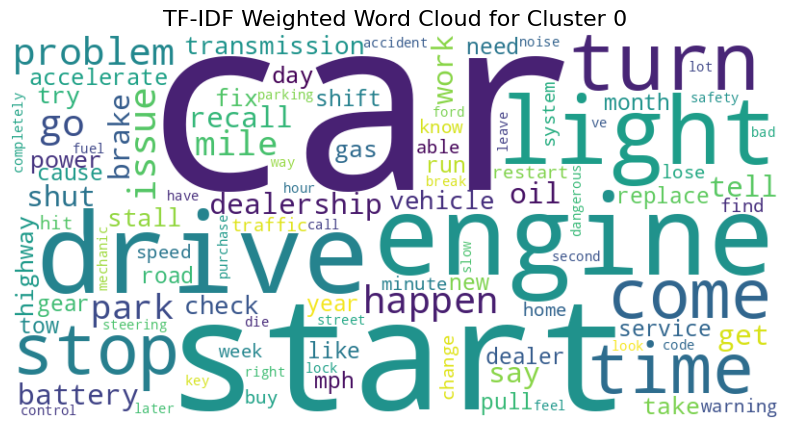

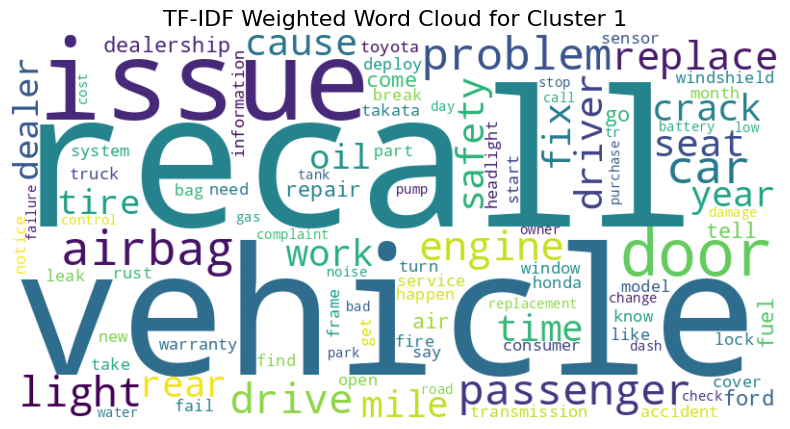

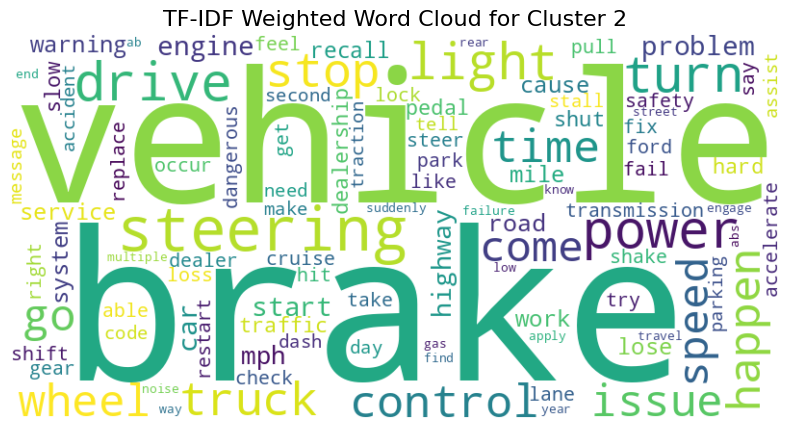

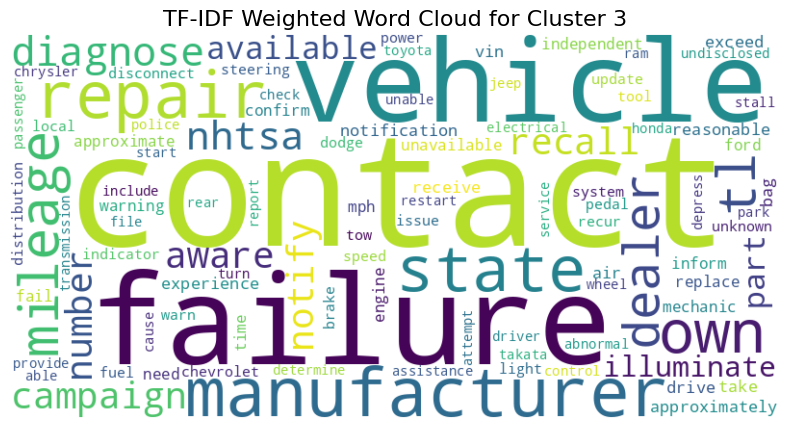

In [21]:
terms = tfidf.get_feature_names_out()
centroids = kmeans.cluster_centers_

for cluster_num, centroid in enumerate(centroids):
    # Create a dictionary {term: weight} from centroid values
    word_weights = {terms[i]: centroid[i] for i in range(len(terms)) if centroid[i] > 0}

    # Generate word cloud from TF-IDF weights
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=100
    ).generate_from_frequencies(word_weights)

    # Plot
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'TF-IDF Weighted Word Cloud for Cluster {cluster_num}', fontsize=16)
    plt.show()

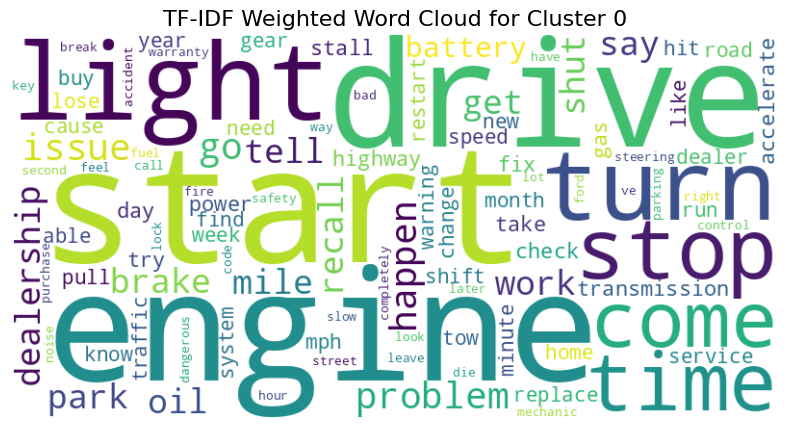

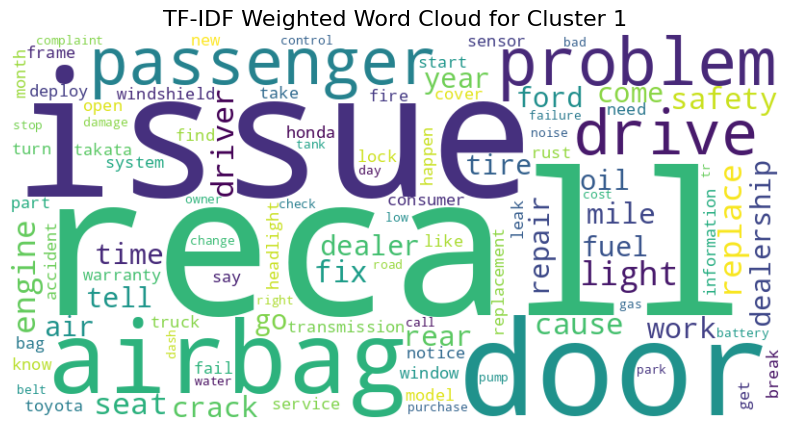

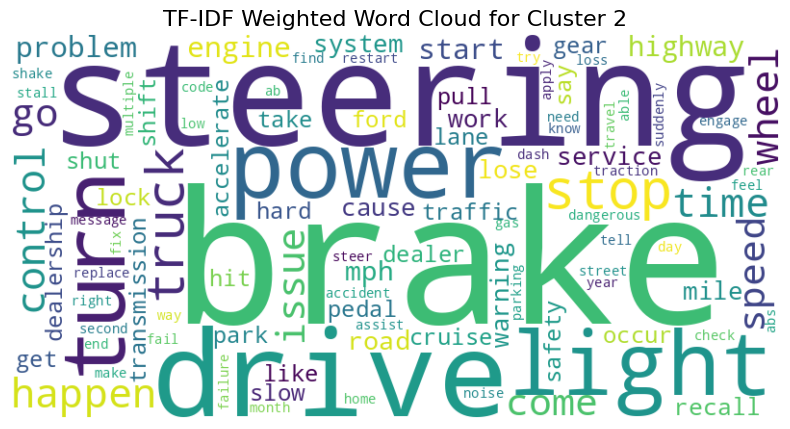

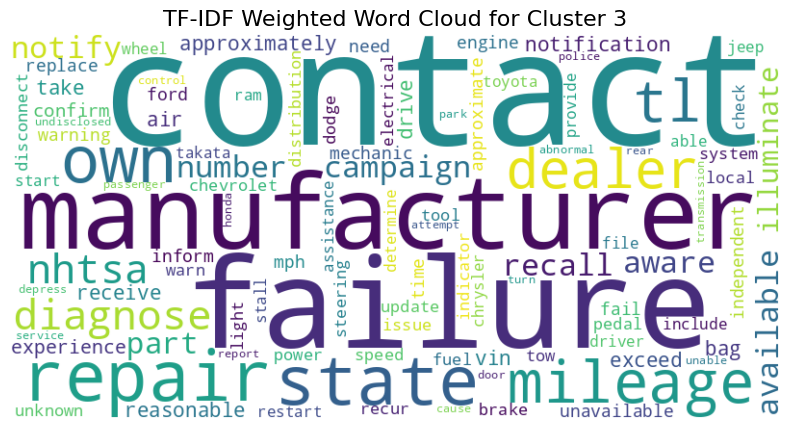

In [23]:
terms = tfidf.get_feature_names_out()
centroids = kmeans.cluster_centers_

# List of words you want to exclude
exclude_words = {"vehicle", "car"}  # Add your own words here

for cluster_num, centroid in enumerate(centroids):
    # Filter out the excluded words
    word_weights = {
        terms[i]: centroid[i]
        for i in range(len(terms))
        if centroid[i] > 0 and terms[i] not in exclude_words
    }

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=100
    ).generate_from_frequencies(word_weights)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'TF-IDF Weighted Word Cloud for Cluster {cluster_num}', fontsize=16)
    plt.show()

#### 🔎 Interpretation of Clusters (k = 4)

##### 🟦 Cluster 0 — "General Performance Issues"
- **Top words**: car, start, engine, drive, light, turn, stop, time, come, problem  
- **Interpretation**: Captures engine startup, driveability, and lighting problems — classic user-reported performance issues.  
- **Suggested label**: **Performance & Operational Behavior**

---

##### 🟥 Cluster 1 — "Recall and Safety Equipment"
- **Top words**: recall, vehicle, issue, door, airbag, car, problem, passenger, drive, light  
- **Interpretation**: Strong presence of recall, airbags, and doors → represents regulatory/safety concerns.  
- **Suggested label**: **Recall & Safety Equipment (Airbags, Doors)**

---

##### 🟩 Cluster 2 — "Braking and Steering Systems"
- **Top words**: brake, vehicle, steering, drive, power, light, turn, stop, truck, happen  
- **Interpretation**: Reflects braking and steering issues, which impact vehicle control and safety.  
- **Suggested label**: **Brakes & Steering Control**

---

##### 🟨 Cluster 3 — "Manufacturer & Repair Experience"
- **Top words**: contact, failure, vehicle, manufacturer, repair, state, own, mileage, tl, dealer  
- **Interpretation**: Focused on interactions with manufacturers, repair processes, ownership, and service experiences.  
- **Suggested label**: **Manufacturer Interaction & Repair Process**

In [23]:
cluster_names = {
    0: "Performance",
    1: "Recall & Safety",
    2: "Brakes & Steering",
    3: "Repair & Manufacturer"
}

df["cluster_name"] = df["cluster"].map(cluster_names)
df.to_parquet("complaints_with_cluster_names.parquet", index=False)

### Step 5: Temporal Pattern Analysis

In [ ]:

df = pd.read_parquet("complaints_with_cluster_names.parquet")

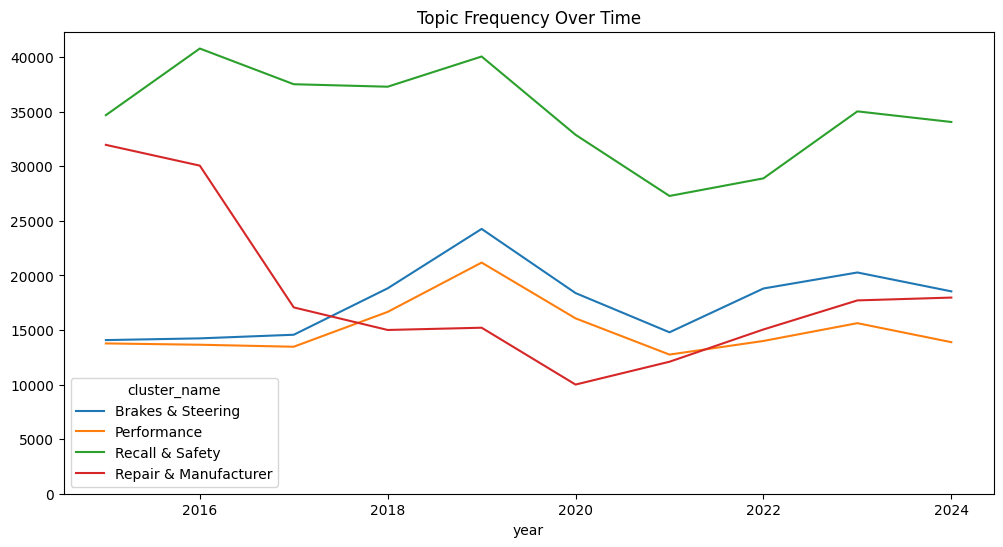

In [ ]:
df["FAILDATE"] = pd.to_datetime(df["FAILDATE"], errors="coerce")
df["year"] = df["FAILDATE"].dt.year
df = df[df["year"] <= 2024]


topic_counts = df.groupby(["year", "cluster_name"]).size().unstack().fillna(0)

# Plot time series for selected clusters
ax =topic_counts.plot(kind="line", figsize=(12, 6), title="Topic Frequency Over Time")
ax.set_ylim(bottom=0)

plt.show()

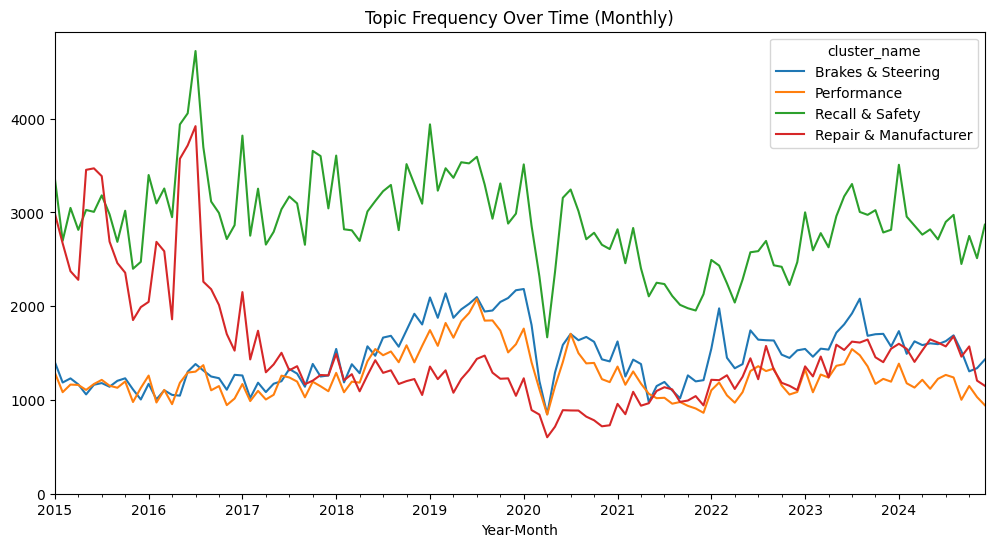

In [9]:
df["FAILDATE"] = pd.to_datetime(df["FAILDATE"], errors="coerce")
df["year_month"] = df["FAILDATE"].dt.to_period("M")  # Use period for proper grouping by month

df = df[df["year_month"] <= "2025-3"]  # Adjust filter if needed

topic_counts = df.groupby(["year_month", "cluster_name"]).size().unstack().fillna(0)

# Plot time series for selected clusters (now monthly)
ax = topic_counts.plot(kind="line", figsize=(12, 6), title="Topic Frequency Over Time (Monthly)")
ax.set_ylim(bottom=0)
ax.set_xlabel("Year-Month")
plt.show()

#### 📈 Topic Frequency Over Time
This chart shows how the volume of complaints across four identified issue clusters changed from 2015 to 2024, based on unstructured narrative clustering.




##### 🔧 Brakes & Steering (Blue Line)
- **Steady growth from 2015 to 2019**, peaking around 2019, followed by a dip during 2020–2021, and a moderate rebound afterward.
- This pattern may correspond to increased consumer concern around mechanical failures, especially leading into the pandemic period, which disrupted production and maintenance cycles.

##### 🔌 Performance (Orange Line)
- **Fairly stable** in earlier years, with a noticeable spike in 2019 and decline thereafter.
- The spike could reflect frustration with newer vehicle technologies (e.g., hybrids or software bugs), while the decline may be attributed to improvements in newer model rollouts or lower reporting due to COVID-related shifts in driving patterns.

##### 🛑 Recall & Safety (Green Line)
- **Highest and most consistent complaint category** overall.
- Peaks in 2016 and 2019 suggest correspondence with **major recall waves**, including those related to Takata airbags and other high-profile safety failures.
- Although declining post-2020, it remains significantly above other categories, suggesting that **safety-related concerns continue to dominate public perception**.

##### 🧰 Repair & Manufacturer (Red Line)
- **Declining sharply from 2015 to 2020**, then rebounding from 2021 onward.
- The post-2021 rise may reflect **backlogs in warranty and repair services** due to COVID-19, supply chain delays, or shifting customer service expectations.



In [ ]:
# years = df['year'].unique()

# for year in sorted(years):
#     year_df = df[df['year'] == year]
#     if year_df.empty:
#         continue

#     # Transform the text of this year's subset using the already fitted tfidf vectorizer
#     X_year_tfidf = tfidf.transform(year_df["cd_text"])

#     # Sum TF-IDF scores across all documents for each term
#     tfidf_sum = X_year_tfidf.sum(axis=0).A1  # .A1 to flatten matrix to array
#     term_weights = {term: tfidf_sum[idx] for idx, term in enumerate(tfidf.get_feature_names_out()) if tfidf_sum[idx] > 0}

#     # Generate word cloud
#     wordcloud = WordCloud(
#         width=800,
#         height=400,
#         background_color='white',
#         max_words=100
#     ).generate_from_frequencies(term_weights)

#     # Plot
#     plt.figure(figsize=(10, 5))
#     plt.imshow(wordcloud, interpolation='bilinear')
#     plt.axis('off')
#     plt.title(f'TF-IDF Weighted Word Cloud for Year {year}', fontsize=16)
#     plt.show()

#### 🧭 Policy Insight


This longitudinal trend analysis provides regulators and automakers with **early signals of systemic shifts** in consumer concern — especially valuable for anticipating where regulatory or consumer protection efforts are most needed.

##### 📌 Actionable Recommendations:
- **NHTSA** should cross-reference **Recall & Safety peaks** with recall campaigns to ensure transparency and assess if any spikes precede formal recall announcements.
- **OEM regulators** should investigate the **post-2021 increase in repair-related complaints**, identifying whether service centers are meeting customer obligations and if extended warranties are being honored appropriately.
- **Automakers** can use this data to proactively **target updates to service bulletins** — especially in years where certain complaint categories spike.
- **DOT/State Agencies** can use these trends to plan public inspection and education initiatives around braking systems or safety recalls during peak years.
- **Consumer watchdog groups** should amplify messaging in years where performance or safety concerns trend upward, encouraging drivers to report and act on mechanical failures.

This kind of time-series analysis, derived from unstructured narratives, allows for **proactive rather than reactive oversight** — turning raw complaints into policy-shaping signals.

## Further Exploration of Entity Reconition

### Step 1: Explode entities into one entity per row

In [8]:

df_entities = df[["cluster", "entities"]].explode("entities")

### Step 2: Count top entities per cluster

In [9]:
top_entities_per_cluster = (
    df_entities
    .groupby(["cluster", "entities"])
    .size()
    .reset_index(name="count")
    .sort_values(["cluster", "count"], ascending=[True, False])
)


In [10]:
top_entities_per_cluster.groupby("cluster").head(5)

,cluster,entities,count
5609,0,car,96949
30869,0,problem,23351
14757,0,ford,16019
49392,0,vehicle,10008
17978,0,hyundai,9294
83038,1,ford,40990
160966,1,vehicle,35548
119013,1,problem,32481
66092,1,car,28962
157110,1,toyota,22346


### 📊 Heatmap 1: NER-Based Brand Mentions from Unstructured Text

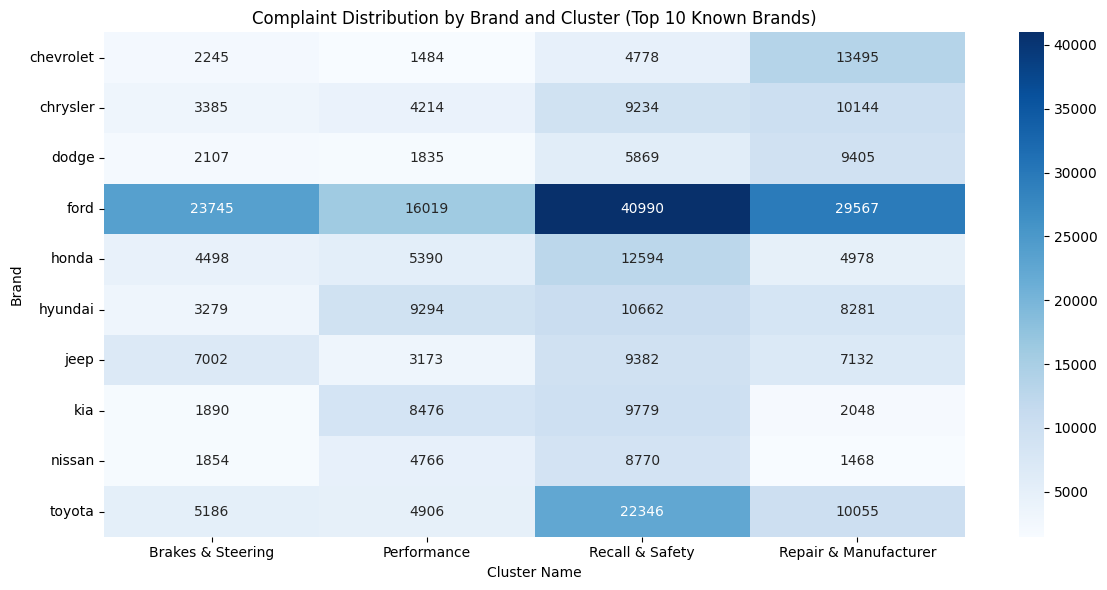

In [13]:
cluster_names = {
    0: "Performance",
    1: "Recall & Safety",
    2: "Brakes & Steering",
    3: "Repair & Manufacturer"
}

known_brands = [
    "ford", "toyota", "chevrolet", "honda", "hyundai", "kia",
    "nissan", "jeep", "subaru", "volkswagen", "gmc", "ram", "dodge",
    "bmw", "mercedes", "tesla", "cadillac", "chrysler", "mazda", 'volkswagen'
]

df_entities = df[["cluster", "entities"]].explode("entities")
df_entities["cluster name"] = df_entities["cluster"].map(cluster_names)
brand_clusters = df_entities[df_entities["entities"].isin(known_brands)]
brand_counts = brand_clusters["entities"].value_counts()
top_brands = brand_counts.head(10).index.tolist()
top_brand_clusters = brand_clusters[brand_clusters["entities"].isin(top_brands)]
brand_cluster_counts = (
    top_brand_clusters.groupby(["entities", "cluster name"])
    .size()
    .unstack(fill_value=0)
)

plt.figure(figsize=(12, 6))
sns.heatmap(brand_cluster_counts, annot=True, fmt="d", cmap="Blues")
plt.title("Complaint Distribution by Brand and Cluster (Top 10 Known Brands)")
plt.xlabel("Cluster Name")
plt.ylabel("Brand")
plt.tight_layout()
plt.show()




**What It Shows:**
- Brand names like **Ford**, **Toyota**, and **Hyundai** were extracted directly from the complaint narratives using entity recognition.
- **Ford** shows overwhelming mentions across all clusters, especially *Recall & Safety* and *Brakes & Steering*.
- **Toyota** has a high concentration in *Brakes & Steering*, while **Hyundai** appears more in *Performance* and *Repair* complaints.

**Policy Insight:**
This analysis reflects how the public spontaneously refers to brands in their own words, independent of structured form fields. It complements structured data by offering an alternate view into brand-related sentiment and early risk signals.

**Actionable Recommendations:**
- **NHTSA** should establish an early warning pipeline using NER-based analysis to flag brands disproportionately mentioned in *Recall & Safety* clusters, even before formal recall codes are entered.
- **OEM regulators** should cross-reference frequently mentioned brands in complaint narratives with internal service bulletins to detect underreported failure patterns.
- **Consumer protection agencies** should prioritize education or alert campaigns for brands with high unstructured complaint volumes to ensure customers are aware of service rights or pending recalls.


### 🏭 Heatmap 2: Structured `MFR_NAME` (Manufacturer Entity)

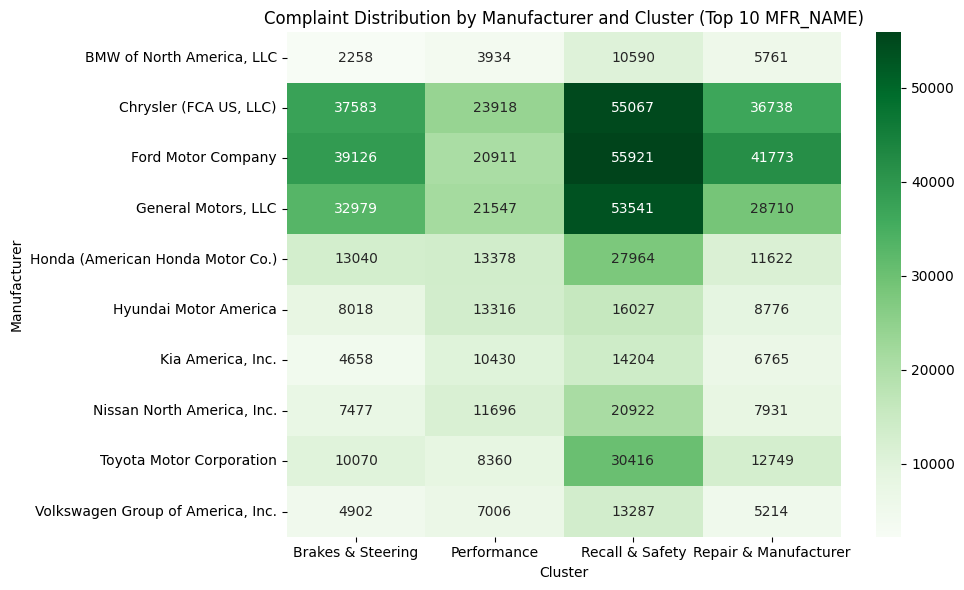

In [12]:
# Compare with the `MFR_NAME` column based heatmap
df["cluster name"] = df["cluster"].map(cluster_names)
top_mfr = df["MFR_NAME"].value_counts().head(10).index.tolist()
df_mfr = df[df["MFR_NAME"].isin(top_mfr)]
mfr_cluster_counts = (
    df_mfr.groupby(["MFR_NAME", "cluster name"])
    .size()
    .unstack(fill_value=0)
)

plt.figure(figsize=(10, 6))
sns.heatmap(mfr_cluster_counts, annot=True, fmt="d", cmap="Greens")
plt.title("Complaint Distribution by Manufacturer and Cluster (Top 10 MFR_NAME)")
plt.xlabel("Cluster")
plt.ylabel("Manufacturer")
plt.tight_layout()
plt.show()



**What It Shows:**
- **Ford**, **Chrysler**, and **General Motors** top the list with high volumes in *Recall & Safety*, confirming known recall activity.
- **BMW** exhibits an outlier pattern, with complaints concentrated in *Repair & Manufacturer*, potentially indicating issues with service experience.

**Policy Insight:**
Structured manufacturer data provides the necessary backbone for official accountability and enforcement. High volumes in certain clusters reinforce the validity of those clusters and help align complaint trends with regulatory actions.

**Actionable Recommendations:**
- **NHTSA** should initiate compliance audits for manufacturers with large *Recall & Safety* volumes that exceed their official recall counts.
- **FTC** and state attorneys general should investigate manufacturers with elevated *Repair & Manufacturer* complaints for possible violations of warranty or service laws.
- **Congressional transportation committees** should mandate quarterly reporting from manufacturers on consumer complaints, cross-checked against public datasets like NHTSA’s database.


### 🚗 Heatmap 3: Structured `MAKETXT` (Vehicle Make)

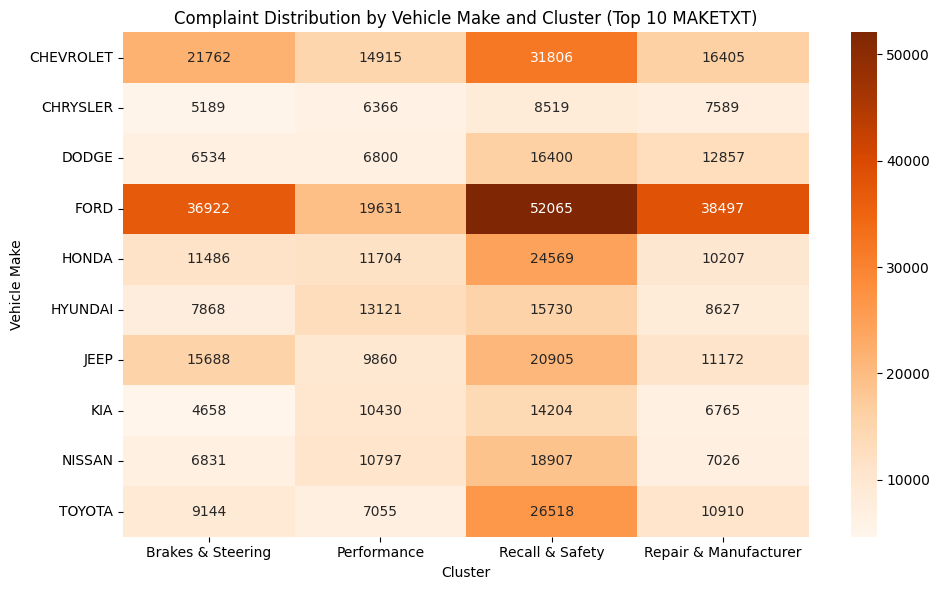

In [14]:
top_makes = df["MAKETXT"].value_counts().head(10).index.tolist()
df_make = df[df["MAKETXT"].isin(top_makes)]
make_cluster_counts = (
    df_make.groupby(["MAKETXT", "cluster name"])
    .size()
    .unstack(fill_value=0)
)

plt.figure(figsize=(10, 6))
sns.heatmap(make_cluster_counts, annot=True, fmt="d", cmap="Oranges")
plt.title("Complaint Distribution by Vehicle Make and Cluster (Top 10 MAKETXT)")
plt.xlabel("Cluster")
plt.ylabel("Vehicle Make")
plt.tight_layout()
plt.show()


**What It Shows:**
- **Ford**, **Chevrolet**, and **Dodge** have dominant presence in *Recall & Safety*, while **Jeep** is strongly represented in *Brakes & Steering*.
- **Toyota** and **Honda** show more balanced distributions, with notable presence in *Performance* and *Repair*.

**Policy Insight:**
Vehicle make data offers a public-facing representation of risk, enabling agencies to identify brand-level systemic issues across multiple models and years.

**Actionable Recommendations:**
- **NHTSA** should require automakers to include MAKE-level complaint distributions when filing formal defect reports or recall notices.
- **Consumer Reports** and similar rating agencies can use MAKE-level complaint clusters to supplement safety and reliability scores.
- **State DMVs** should consider flagging high-risk makes during inspections or registration renewals to recommend early mechanical checks or recall verifications.


### 🚙 Heatmap 4: Structured `MODELTXT` (Vehicle Model)

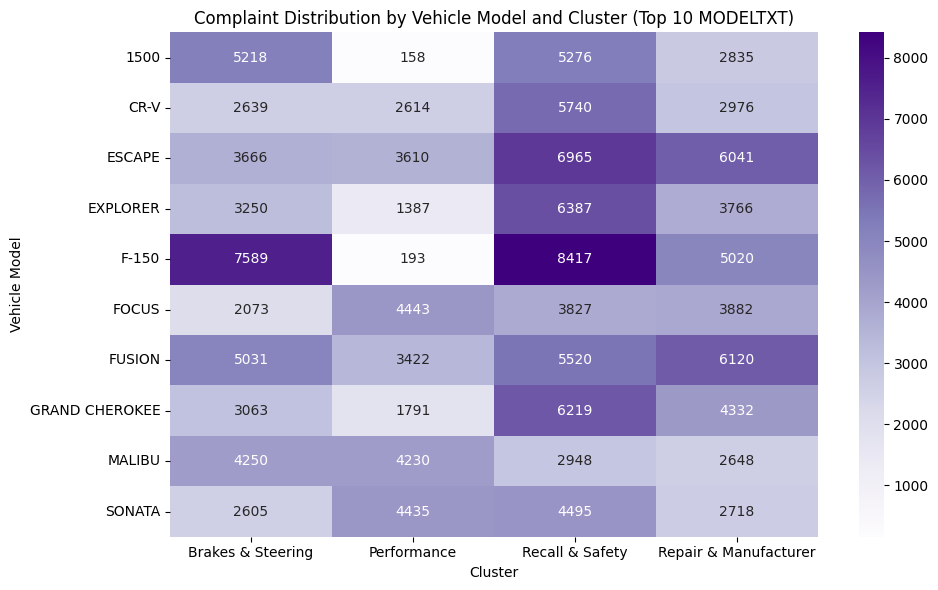

In [16]:
top_models = df["MODELTXT"].value_counts().head(10).index.tolist()
df_model = df[df["MODELTXT"].isin(top_models)]
model_cluster_counts = (
    df_model.groupby(["MODELTXT", "cluster name"])
    .size()
    .unstack(fill_value=0)
)

plt.figure(figsize=(10, 6))
sns.heatmap(model_cluster_counts, annot=True, fmt="d", cmap="Purples")
plt.title("Complaint Distribution by Vehicle Model and Cluster (Top 10 MODELTXT)")
plt.xlabel("Cluster")
plt.ylabel("Vehicle Model")
plt.tight_layout()
plt.show()

**What It Shows:**
- **F-150**, **Escape**, and **Explorer** show large complaint volumes in *Brakes & Steering* and *Recall & Safety*, validating known field issues.
- **Focus** and **Fusion** display more complaints in *Performance* and *Repair*, pointing to longer-term user dissatisfaction and maintenance needs.

**Policy Insight:**
Model-level analysis enables regulators and manufacturers to pinpoint specific vehicle variants associated with recurring failures, allowing for more efficient technical investigations and consumer alerts.

**Actionable Recommendations:**
- **NHTSA** should mandate model-level defect tracking by failure type and initiate deeper technical investigations when certain models cluster in high-risk categories.
- **Automakers** should include heatmap-style visualizations of model-specific complaints in Technical Service Bulletins (TSBs).
- **Insurance regulators** could incorporate complaint-based model profiles into premium adjustment algorithms, rewarding reliability and penalizing known issue-prone designs.
